In [1]:
import numpy as np
from tqdm import tqdm
import networkx as nx
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt

In [2]:
def random_split(X, y, n, seed):
    """Equally split data between n agents"""
    rng = np.random.default_rng(seed)
    perm = rng.permutation(y.shape[0])
    X_split = np.array_split(X[perm], n)  #np.stack to keep as a np array
    y_split = np.array_split(y[perm], n)
    return X_split, y_split

# Graph implementation
def generate_graph(cluster_sizes=[100,100], pin=0.5, pout=0.01, seed=0):
    """Generate a random connected graph"""
    probs = np.array([[pin, pout, pout],[pout, pin, pout],[pout, pout, pin]])
    while True:
        g = nx.stochastic_block_model(cluster_sizes, probs, seed=0)
        if nx.algorithms.components.is_connected(g):
            return g

In [3]:
def get_data(data):
    data = load_svmlight_file(data)
    return data[0].toarray(), data[1]
data = "./abalone_scale.txt"
X, y = get_data(data)


X, y = random_split(X, y, 3, 42)
X1 = X[0][:, 0:4]
X2 = X[1][:, 0: 6]
X3 = X[2][:, 0:]
y1 = y[0]
y2 = y[1]
y3 = y[2]

X_test = [np.concatenate([X[1], X[2]], axis=0), np.concatenate([X[0], X[2]], axis=0), np.concatenate([X[0], X[1]], axis=0)]
y_test = [np.concatenate((y[1], y[2])), np.concatenate((y[0], y[2])), np.concatenate((y[0], y[1]))]


subset_ranges = [np.arange(0, 4), np.arange(0, 6), np.arange(0, 8)]
subset_lengths = [subset_ranges[0].shape[0], subset_ranges[1].shape[0], subset_ranges[2].shape[0]]

X1, y1 = random_split(X1, y1, 10, 42)
X2, y2 = random_split(X2, y2, 10, 42)
X3, y3 = random_split(X3, y3, 10, 42)

In [4]:
len(X_test)

3

In [5]:



cluster_sizes = [10, 10, 10]
pin = 0.5
pout = 0.1
seed = 0
alpha = 1e-2
lamda = 0#1e-1#1e-3#1e-1#1e-3
eta = 1 * 1e-2
d0 = min(subset_lengths)
no_users = sum(cluster_sizes)
batch_size = 20
epochs = 1
it = 500

# Set a random seed for reproducibility
seed = 17

np.random.seed(seed)
num_features = 4

In [6]:
X = [X1, X2, X3]
y = [y1, y2, y3]
input_sizes = [X1[0].shape[1], X2[0].shape[1], X3[0].shape[1]]

X_train = []
y_train = []
X_temp = []
y_temp = []


for i, cluster_size in enumerate(cluster_sizes):
    for j in range(cluster_size):

        
        X_train.append(X[i][j])
        y_train.append(y[i][j])
        
        X_temp.append(X_test[i][:, subset_ranges[i]])
        y_temp.append(y_test[i])
X_test = X_temp 
y_test = y_temp


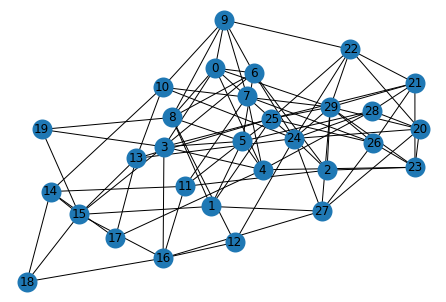

In [7]:
G = generate_graph(cluster_sizes, pin, pout, seed)
nx.draw(G, with_labels=True, node_size=100, alpha=1, linewidths=10)
plt.show()

In [8]:
def loss(w, A, b):
    z = b * np.dot(A, w)
    tmp = np.minimum(z, 0)
    loss = np.log((np.exp(tmp) + np.exp(tmp - z)) / np.exp(tmp))
    loss_sum = np.sum(loss) / len(b)
    reg = (np.linalg.norm(w) ** 2) * l2 / 2
    return loss_sum + reg


def linear_regression_loss(w, A, b):
    predictions = np.dot(A, w)
    errors = predictions - b
    mse_loss = np.mean(errors**2) / 2
    return mse_loss


def gradient(w, A, b):
    m = A.shape[0]
    bAw = b * (A @ w)
    temp = 1. / (1. + np.exp(bAw))
    res = -(A.T @ (b * temp))/m + l2 * w
    return res


def linear_regression_gradient(w, A, b):
    m = A.shape[0]
    predictions = np.dot(A, w)
    errors = predictions - b
    
    # Gradient without regularization
    gradient = np.dot(A.T, errors) / m
    
    return gradient


def degrees(A):
    """Return the degrees of each node of a graph from its adjacency matrix"""
    return np.sum(A, axis=0).reshape(A.shape[0], 1)



def metropolis_weights(Adj):
    N = np.shape(Adj)[0]
    degree = degrees(Adj)
    W = np.zeros([N, N])
    for i in range(N):
        N_i = np.nonzero(Adj[i, :])[1]  # Fixed Neighbors
        for j in N_i:
            W[i, j] = 1/(1+np.max([degree[i], degree[j]]))
        W[i, i] = 1 - np.sum(W[i, :])
    return W


adjacency_matrix = nx.linalg.graphmatrix.adjacency_matrix(G)
comm_matrix = metropolis_weights(adjacency_matrix)

print(G.number_of_edges())
print(G.number_of_nodes())

90
30


In [9]:
theta = [np.zeros(subset_lengths[i]) for i, cluster_size in enumerate(cluster_sizes) for j in range(cluster_size)]

In [10]:
n_iters = 200
alpha = 0.01
group_size = 10
losses = []
accuracies = []

theta0 = np.zeros(num_features)
op_gap_dsgd = np.zeros(shape=[n_iters])

task_loss = {'0':[],
                '1':[],
                '2':[]}
task_acc = {'0':[],
            '1':[],
            '2':[]}




for k in range(n_iters):  
    
    for i in range(no_users):
        grad = linear_regression_gradient(theta[i], X_train[i], y_train[i])
        theta[i] = theta[i] - alpha*grad
    
    
    acc = 0
    local_loss = 0
    
    total_loss = 0
    total_acc = 0
    
    for i in range(no_users):
        acc += np.mean(np.abs(np.dot(X_test[i], theta[i]) - y_test[i]) < 3.)
        local_loss += linear_regression_loss(theta[i], X_test[i], y_test[i])
        if (i + 1) % 10 == 0:
            task_loss[str(i // 10)].append(local_loss / 10)
            task_acc[str(i // 10)].append(acc / 10)
            total_loss += local_loss
            total_acc += acc
            acc = 0
            local_loss = 0
        
        
    losses.append(total_loss / no_users)
    accuracies.append(total_acc / no_users)
    
    print("%d:   Loss:   %2.6f,     Acc:    %2.6f"%(k, accuracies[-1], losses[-1]))
    
    
    


0:   Loss:   0.004058,     Acc:    53.469009
1:   Loss:   0.004058,     Acc:    52.429965
2:   Loss:   0.004058,     Acc:    51.417584
3:   Loss:   0.004058,     Acc:    50.431079
4:   Loss:   0.004848,     Acc:    49.469689
5:   Loss:   0.007708,     Acc:    48.532680
6:   Loss:   0.008630,     Acc:    47.619338
7:   Loss:   0.008917,     Acc:    46.728974
8:   Loss:   0.009492,     Acc:    45.860919
9:   Loss:   0.010569,     Acc:    45.014529
10:   Loss:   0.014459,     Acc:    44.189177
11:   Loss:   0.017798,     Acc:    43.384257
12:   Loss:   0.020647,     Acc:    42.599183
13:   Loss:   0.022394,     Acc:    41.833387
14:   Loss:   0.022993,     Acc:    41.086319
15:   Loss:   0.023783,     Acc:    40.357445
16:   Loss:   0.025219,     Acc:    39.646251
17:   Loss:   0.028881,     Acc:    38.952236
18:   Loss:   0.033525,     Acc:    38.274916
19:   Loss:   0.037080,     Acc:    37.613822
20:   Loss:   0.041664,     Acc:    36.968500
21:   Loss:   0.046093,     Acc:    36.33851

181:   Loss:   0.677260,     Acc:    7.257215
182:   Loss:   0.679032,     Acc:    7.221186
183:   Loss:   0.680588,     Acc:    7.185639
184:   Loss:   0.682216,     Acc:    7.150564
185:   Loss:   0.683832,     Acc:    7.115956
186:   Loss:   0.685712,     Acc:    7.081805
187:   Loss:   0.686909,     Acc:    7.048106
188:   Loss:   0.688453,     Acc:    7.014851
189:   Loss:   0.690034,     Acc:    6.982032
190:   Loss:   0.691422,     Acc:    6.949644
191:   Loss:   0.692895,     Acc:    6.917678
192:   Loss:   0.694403,     Acc:    6.886130
193:   Loss:   0.695636,     Acc:    6.854991
194:   Loss:   0.697037,     Acc:    6.824256
195:   Loss:   0.698486,     Acc:    6.793919
196:   Loss:   0.699790,     Acc:    6.763972
197:   Loss:   0.701215,     Acc:    6.734411
198:   Loss:   0.702580,     Acc:    6.705229
199:   Loss:   0.703992,     Acc:    6.676421


0
1
2


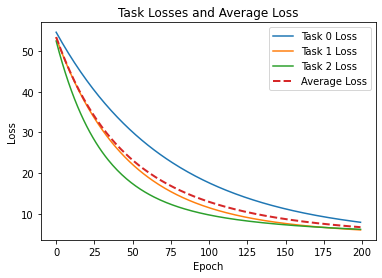

In [11]:


# Load and plot each task loss
lamda = 0
all_task_losses = []
fig, ax = plt.subplots()
for key in task_loss.keys():
    # Load the NumPy array
    print(key)
    array_loss = task_loss[key]
    
    # Append the task loss to the list
    all_task_losses.append(array_loss)
    
    # Plot the task loss
    plt.plot(array_loss, label='Task ' + key + ' Loss')

# Calculate and plot the average loss
average_loss = np.mean(all_task_losses, axis=0)
plt.plot(average_loss, label='Average Loss', linestyle='--', linewidth=2)

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Task Losses and Average Loss')
plt.legend()

# Show the plot
plt.show()